In [80]:
import or_gym
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import poisson

In [174]:
env = or_gym.make('InvManagement-v1')

In [175]:
env.action_space.high

array([100,  90,  80], dtype=int16)

In [176]:
states = []
while True:
    action = env.action_space.high
    s, r, d, _ = env.step(action)
    states.append(s)
    if d:
        break

In [177]:
states

[array([ 79.,   0., 110.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,  90.,  80.]),
 array([ 58.,   0.,  20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 100.,  90.,  80., 100.,  90.,  80.]),
 array([ 39.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 100.,  90.,  80., 100.,  90.,  80., 100.,  90.,  80.]),
 array([120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,
         90.,  80., 100.,  90.,  80., 100.,  90.,  80., 100.,  90.,  80.]),
 array([ 88.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.

# Policy Iteration

Example taken from [this page](https://www.datahubbs.com/what-is-dynamic-programming/).

In [11]:
# Policy requires np array for each action/state combination
env.observation_space.low, env.observation_space.high,

(array([-30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000,
        -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000,
        -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000,
        -30000, -30000, -30000, -30000, -30000, -30000, -30000, -30000,
        -30000], dtype=int32),
 array([3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
        3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
        3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000],
       dtype=int32))

In [92]:
mu = 20
demand_upper = np.min([k if poisson.cdf(k, mu) >= 0.975 else 50 for k in range(50)])
demand_lower = np.max([k if poisson.cdf(k, mu) <= 0.025 else 0 for k in range(20)])
demand_range = np.arange(demand_lower, demand_upper + 1)
demand_range

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29])

In [94]:
# Policy for retail stage without backlog
action_range = np.arange(env.action_space.low[0], env.action_space.high[0])
inventory_range = np.arange(env.c[0] + 1)
# Assume uniform demand distribution from 0-10
time_steps = 10

In [134]:
V = np.zeros((action_range.max()+1, inventory_range.max()+1,
                  len(demand_range), time_steps))
# Assume instant order fulfillment
# Set terminal state values at t_final

def calculate_reward(env, inventory, demand):
    sales = min(inventory, demand)
    lost_sales = max(demand - inventory, 0)
    inventory -= sales
    time_steps = 10
    return env.alpha**time_steps*np.sum(env.unit_price*sales - 
        (env.unit_cost + env.demand_cost*lost_sales + env.holding_cost*inventory))

In [135]:
for i in inventory_range:
    for idx, d in enumerate(demand_range):
        reward = calculate_reward(env, i, d)
        V[:, i, idx, -1] += reward

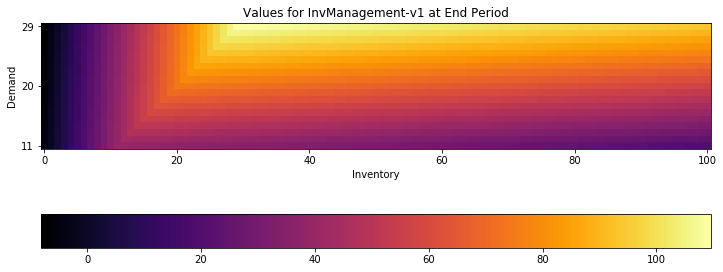

In [136]:
dr_locs = np.array([0, 9, len(demand_range)-1])
plt.figure(figsize=(12,8))
plt.imshow(V[0, :, :, -1].T, cmap='inferno', interpolation='nearest')
plt.ylabel('Demand')
plt.xlabel('Inventory')
plt.yticks(dr_locs, demand_range[dr_locs])
plt.gca().invert_yaxis()
plt.title('Values for {} at End Period'.format(env.spec.id))
plt.colorbar(orientation='horizontal')
plt.show()

In [138]:
V.max()

109.50748284389682

In [141]:
np.where(V[0, :, :, -1] == V.max())

(array([29]), array([18]))

In [148]:
calculate_reward(env, 28, 28)

105.63600617769845

In [149]:
items = np.arange(7)
values = np.array([7, 9, 5, 12, 14, 6, 12])
time = np.array([3, 4, 2, 6, 7, 3, 5])

In [164]:
def sort_and_pack(items, values, weights, capacity=15):
    v_density = values/weights
    vd_idx = np.argsort(v_density)[::-1]
    vd_array = v_density[vd_idx]
    kp_w, kp_v, kp_idx = [], [], []
    while len(vd_array) > 0 and sum(kp_w) < capacity:
        max_item = vd_idx[0].copy()
        item_weight = weights[max_item]
        if item_weight + sum(kp_w) <= capacity:
            # Pack item 
            kp_w.append(item_weight)
            kp_v.append(values[max_item])
            kp_idx.append(max_item)
        
        vd_idx = vd_idx[1:].copy()
        if len(vd_idx) == 0:
            break
    return kp_idx, sum(kp_v), sum(kp_w)

In [165]:
sort_and_pack(items, values, time, 15)

([2, 6, 0, 1], 33, 14)

In [158]:
values/time

array([2.33333333, 2.25      , 2.5       , 2.        , 2.        ,
       2.        , 2.4       ])

In [166]:
env = or_gym.make('Knapsack-v1')

In [167]:
from or_gym.algos.knapsack.heuristics import *

In [170]:
env.N = len(items)
env.item_values = values.copy()
env.item_weights = time.copy()
env.max_weight = 15

In [172]:
a, r = bkp_heuristic(env)

In [173]:
sum(r)

33